# <font color=blue><div align="center">Seats Allocation within an Aircraft</div></font>

### <font color=blue><div align="center">29-02-2024</div></font>

## Modules

In [224]:
# Basic modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table
import random

# Gurobi module
from gurobipy import *

## Data Extraction

In [225]:
# Load the Excel file into a pandas DataFrame


df_21Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=0 , skipfooter=2)
df_22Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=1 , skipfooter=2)
df_23Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=2 , skipfooter=2)
df_24Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=3 , skipfooter=2)
df_30Oct = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=4 , skipfooter=2)
df_05Nov = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=5 , skipfooter=2)
df_07Nov = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=6 , skipfooter=2)


In [226]:
# Display the DataFrame
df = df_07Nov
df

,Numéro du groupe,Femmes,Hommes,WCHR,TransitTime
0,1,1.0,NaN,NaN,00:55:00
1,2,NaN,1.0,NaN,00:00:00
2,3,1.0,NaN,NaN,01:15:00
3,4,1.0,1.0,NaN,03:15:00
4,5,1.0,NaN,NaN,00:00:00
...,...,...,...,...,...
84,85,NaN,2.0,NaN,00:00:00
85,86,1.0,NaN,1.0,00:00:00
86,87,1.0,NaN,NaN,03:15:00
87,88,2.0,1.0,NaN,00:00:00


The code in the cells below creates a dictionary Passengers defined as follows:

- Passengers Keys: IDs of passengers.
- Passengers Items: For each ID in Passengers, we specify its *type* (female: 0, male: 1, disabled: 2), its *group number*, and its *transit time*.

Notice that for passengers with a transit time equal to 0 or larger than 2 hours, the transit time in the dictionary is set to $\infty$


In [227]:
def convert_TransitTime(time_val):

    # Convert time to minutes
    total_minutes = time_val.hour * 60 + time_val.minute
    
    # Check if total minutes is greater than 2 hours or equal to 0
    if total_minutes > 120 or total_minutes == 0:
        return float('inf')  # Return infinity
    else:
        return total_minutes

df['TransitTime'] = df['TransitTime'].apply(convert_TransitTime)

In [228]:
# Create Passengers dictionary
Passengers = dict()
i = 1

number_f = 0
number_m = 0
number_d = 0

transit_times = set()

# Groups : dict[int : List[int]]

Passengers = dict()
i = 1

for group in df.itertuples():
    if not pd.isna(group[2]):
        for k in range(int(group[2])):
            Passengers[i] = {'type': 0, 'group':group[1], 'transit':group[5]}  # 0 <-> female 
            number_f += 1
            transit_times.add(group[5])
            i+=1
    if not pd.isna(group[3]):
        for k in range(int(group[3])):
            Passengers[i] = {'type': 1, 'group':group[1], 'transit':group[5]} # 1 <-> male 
            number_m += 1
            transit_times.add(group[5])
            i+=1
    if not pd.isna(group[4]):
        for k in range(int(group[4])):
            Passengers[i] = {'type': 2, 'group':group[1], 'transit':group[5]} # 2 <-> WCHR
            number_d += 1
            transit_times.add(group[5])
            i+=1
    


    
Passengers 

{1: {'type': 0, 'group': 1, 'transit': 55.0},
 2: {'type': 1, 'group': 2, 'transit': inf},
 3: {'type': 0, 'group': 3, 'transit': 75.0},
 4: {'type': 0, 'group': 4, 'transit': inf},
 5: {'type': 1, 'group': 4, 'transit': inf},
 6: {'type': 0, 'group': 5, 'transit': inf},
 7: {'type': 0, 'group': 6, 'transit': inf},
 8: {'type': 0, 'group': 6, 'transit': inf},
 9: {'type': 2, 'group': 7, 'transit': inf},
 10: {'type': 0, 'group': 8, 'transit': inf},
 11: {'type': 1, 'group': 8, 'transit': inf},
 12: {'type': 1, 'group': 8, 'transit': inf},
 13: {'type': 1, 'group': 8, 'transit': inf},
 14: {'type': 1, 'group': 8, 'transit': inf},
 15: {'type': 0, 'group': 9, 'transit': inf},
 16: {'type': 0, 'group': 9, 'transit': inf},
 17: {'type': 0, 'group': 9, 'transit': inf},
 18: {'type': 0, 'group': 9, 'transit': inf},
 19: {'type': 0, 'group': 10, 'transit': inf},
 20: {'type': 0, 'group': 11, 'transit': inf},
 21: {'type': 1, 'group': 11, 'transit': inf},
 22: {'type': 0, 'group': 12, 'transit

We define a dictionnary *Groups*, containing as keys the ids of groups with more than two passengers and as values, the list of the members of the group

In [229]:
Groups = dict()


for i, passager in Passengers.items():

    if passager['group'] in Groups:
        Groups[passager['group']].append(i)
    else :
        Groups[passager['group']] = [i]

Keys = list(Groups.keys()).copy()


for i in Keys:
        if len(Groups[i]) ==1: del(Groups[i])
Groups

{4: [4, 5],
 6: [7, 8],
 8: [10, 11, 12, 13, 14],
 9: [15, 16, 17, 18],
 11: [20, 21],
 12: [22, 23, 24, 25, 26],
 13: [27, 28, 29, 30],
 14: [31, 32, 33, 34, 35],
 17: [38, 39],
 18: [40, 41, 42, 43, 44],
 20: [46, 47],
 23: [50, 51, 52],
 24: [53, 54, 55, 56],
 26: [58, 59, 60],
 27: [61, 62],
 36: [71, 72],
 38: [74, 75, 76],
 39: [77, 78],
 41: [80, 81],
 42: [82, 83],
 46: [87, 88, 89, 90, 91],
 51: [96, 97],
 57: [103, 104, 105, 106],
 60: [109, 110],
 65: [115, 116, 117, 118],
 67: [120, 121],
 73: [127, 128],
 74: [129, 130, 131],
 75: [132, 133, 134],
 76: [135, 136],
 79: [139, 140],
 81: [142, 143],
 82: [144, 145, 146],
 83: [147, 148, 149],
 84: [150, 151],
 85: [152, 153],
 86: [154, 155],
 88: [157, 158, 159],
 89: [160, 161, 162]}

Definition of parameters necessary for the following steps

In [230]:
weight_f = 70
weight_m = 85
weight_d = 92.5

if sum([4*number_d,number_f,number_m]) <= 174 :
    number_of_rows = 29 #modèle d'avion A320
else :
    number_of_rows = 35 #modèle d'avion A321

number_of_columns = 7 # ajout de la colonne qui correspond à l'allée


## Model

Defining the relevant variables of the problem

The binary variables $AssignmentVarDict[(i,j,k)]$ specify whether the seat located at position $(i,j)$ is occupied by passenger $k$.

In [231]:

m = Model("Seats_Allocation")

AssignmenVarDict = {(i, j, k) : m.addVar(vtype = GRB.BINARY, name=f'x_{i}_{j}_{k}')
                    for i in range(1, number_of_rows + 1)
                    for j in range(1, number_of_columns + 1)
                    for k in range(1, len(Passengers)+1)}

### Les contraintes 

- Every person has one seat

In [232]:
PERSONSEATCONSTDIC = { k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)]
                                                for i in range(1, number_of_rows + 1)
                                                for j in range(1, number_of_columns + 1) ])
                                                == 1)
                                                for k in range(1,len(Passengers)+1) }

- Every seat is allocated to a single person

In [233]:
ALLOCATIONCONSTDIC = { (i,j) : m.addConstr(quicksum([AssignmenVarDict[(i,j,k)]
                                                     for k in range(1, len(Passengers)+1)])
                                                     <=1)
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns+1) }

- Aisle seats are always free

In [234]:
AISLECONSTDIC = { i : m.addConstr(quicksum([AssignmenVarDict[(i,4,k)]
                                                     for k in range(1, len(Passengers)+1)])
                                                     == 0)
                                                     for i in range(1, number_of_rows + 1)   
}

- Barycenter constraint

In [235]:

i_m = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==1])

i_f = quicksum([weight_f * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==0])

i_d = quicksum([weight_d * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==2])

i_bary = (i_m + i_f +i_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

j_m = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==1])

j_f = quicksum([weight_f * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==0])

j_d = quicksum([weight_d * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passengers)+1)
                if Passengers[k]['type']==2])

j_bary = (j_m + j_f + j_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

In [236]:
IMAXBARYCONST = m.addConstr(i_bary <= 17)
IMINBARYCONST = m.addConstr(13 <= i_bary)
JMAXBARYCONST = m.addConstr(j_bary <= 5)
JMINBARYCONST = m.addConstr(3 <= j_bary )

- A disabeled person has 4 seats on the aisle side

In [237]:

SeatPer_WCHR_CONST = {k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)] 
                                               for i in range(1, number_of_rows ) 
                                               for j in [3, 6] 
                                               ]) == 1, name=f"SeatPerWCHR{k}")
                                               for k in range(1, len(Passengers) + 1)
                                               if Passengers[k]['type'] == 2}

for k in range(1, len(Passengers) + 1):
    if Passengers[k]['type'] == 2:
        for i in range(1, number_of_rows):
            for j in [3, 6]:
                m.addConstr(AssignmenVarDict[(i, j, k)] + quicksum(
                      [AssignmenVarDict[(i, j - 1, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i}_{j-1}')
                
                m.addConstr(AssignmenVarDict[(i, j, k)] +quicksum(
                      [AssignmenVarDict[(i+1, j, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i+1}_{j}')
                m.addConstr(AssignmenVarDict[(i, j, k)]+ quicksum(
                      [AssignmenVarDict[(i+1, j - 1, p)] for p in range(1, len(Passengers)+1)]
                      ) <= 1,  
                            name=f'Neighbor_WCHR{k}_{i+1}_{j-1}')

## Objectif Time

- Transit time

In [238]:
transit_obj = quicksum( [ AssignmenVarDict[(i,j,k)]* i*(1/Passengers[k]['transit'])
                      for i in range(1, number_of_rows+1)
                      for j in range(1, number_of_columns+1 )
                      for k in range(1, len(Passengers)+1)
                      if Passengers[k]['transit'] != float('inf') ])

m.setObjective(transit_obj, GRB.MINIMIZE)

m.params.outputflag = 0 

m.update()

## Optimisation

In [239]:
m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()




                                                   z* = 2.39                                                    



In [240]:
z_old = round(transit_obj.getValue(), 2) #saving this value for later

- Transit time visualization

In [241]:
def generate_blue_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
         # Linearly decrease the green component from full (255) to 0
        green_intensity = int(255 * (1 - i / (num_gradations - 1)))
        # Keep the red component at full intensity
        red_intensity = 255
        # Combine the components into a color value
        color_value = f"#{red_intensity:02X}{green_intensity:02X}00"
        gradations.append(color_value)
    return gradations
graduation = generate_blue_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[-i-1]

In [242]:
data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passengers[k]['transit']]
                elif j > 4 :
                    data2[i-1][j-5] = k
                    if Passengers[k]['transit']!=float('inf'): colors2[i-1][j-5] = color_transit[Passengers[k]['transit']]

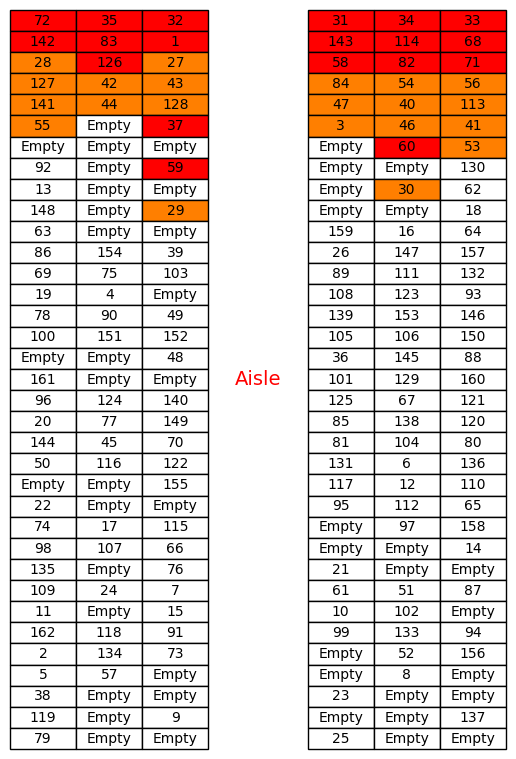

In [243]:

def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

- Disabled visualization

In [244]:
data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['type']==2 :
                        colors1[i-1][j-1] = '#800080'
                        colors1[i-1][j-2] = '#800080'
                        colors1[i][j-1] = '#800080'
                        colors1[i][j-2] = '#800080'
                elif j>4:
                    data2[i-1][j-5] = k
                    if Passengers[k]['type']==2:
                        colors2[i-1][j-5] = '#800080'
                        colors2[i-1][j-6] = '#800080'
                        colors2[i][j-5] = '#800080'
                        colors2[i][j-6] = '#800080'




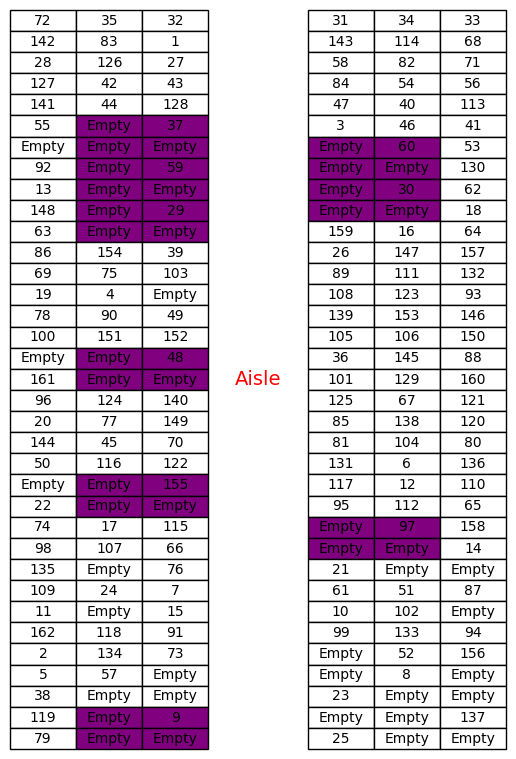

In [245]:
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Objectif Grouping

**Fonction objective : ObjGrouping1**

The binary variables $AssignmentVarGrpDict[(g,i,j, m, n)]$ specify whether the seats located at positions $(i,j)$ and $(i,j+1)$ are occupied by passengers $m$ and $n$ from the group $g$ resp. 

In [246]:

AssignmenVarGrpDict= { (g , i, j , Groups[g][k], Groups[g][l]) : m.addVar(vtype = GRB.BINARY, name=f'Y_{i}_{j}_{Groups[g][k]}_{Groups[g][l]}')
                    for i in range(1, number_of_rows + 1)
                    for j in range(1, number_of_columns)
                    for g in Groups.keys()
                    for k in range(len(Groups[g]))
                    for l in range(len(Groups[g]))

                    }



Defining some contraints to ensure the definition of the variables $AssignmentVarGrpDict[(g,i,j,m,n)]$

In [247]:

GroupingConstDict1 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,j,Groups[g][k],Groups[g][l])] <= AssignmenVarDict[(i,j,Groups[g][k])])
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns)
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(len(Groups[g]))
                                                     }

GroupingConstDict2 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,j,Groups[g][k],Groups[g][l])] <= AssignmenVarDict[(i,j+1,Groups[g][l])])
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in [1,2,5,6]
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(len(Groups[g]))
                                                     }
GroupingAisleConstDict2 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,3,Groups[g][k],Groups[g][l])] <= AssignmenVarDict[(i,5,Groups[g][l])])
                                                     for i in range(1, number_of_rows + 1)
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(len(Groups[g]))
                                                     }

GroupingConstDict3 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,j,Groups[g][k],Groups[g][l])] >= 
                                       AssignmenVarDict[(i,j+1,Groups[g][l])] + AssignmenVarDict[(i,j,Groups[g][k])] -1)
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in [1,2,5,6]
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(len(Groups[g]))
                                                     }
GroupingAisleConstDict3 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,3,Groups[g][k],Groups[g][l])] >= 
                                       AssignmenVarDict[(i,5,Groups[g][l])] + AssignmenVarDict[(i,3,Groups[g][k])] -1)
                                                     for i in range(1, number_of_rows + 1)
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(len(Groups[g]))
                                                     }

obj_grouping = quicksum([AssignmenVarGrpDict[(g, i , j, Groups[g][k], Groups[g][l])]
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in [1,2,5,6]
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(len(Groups[g]))
                         ])

obj_grouping_aisle = quicksum([AssignmenVarGrpDict[(g, i , 3, Groups[g][k], Groups[g][l])]
                                                     for i in range(1, number_of_rows + 1)
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(len(Groups[g]))
                         ])
m.setObjective(2*obj_grouping + obj_grouping_aisle, GRB.MAXIMIZE)






In [248]:

m.params.outputflag = 1

m.update()


Set parameter OutputFlag to value 1


In [249]:
num_vars = m.NumVars
num_vars

116550

## Optimisation


In [250]:
# Set iteration limit
m.setParam(GRB.Param.TimeLimit, 100)  # Change to the desired iterationTime limit

m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()




Set parameter TimeLimit to value 100
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 207251 rows, 116550 columns and 1017660 nonzeros
Model fingerprint: 0xfaf3e966
Variable types: 0 continuous, 116550 integer (116550 binary)
Coefficient statistics:
  Matrix range     [6e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]

MIP start from previous solve produced solution with objective 13 (0.09s)
Loaded MIP start from previous solve with objective 13

Presolve removed 84001 rows and 23220 columns (presolve time = 5s) ...
Presolve removed 122189 rows and 42314 columns
Presolve time: 8.90s
Presolved: 85062 rows, 74236 columns, 615616 nonzeros
Variable types: 0 continuous, 74236 integer (74236 binary)
Deterministic 

- Grouping Visualisation 

In [251]:

def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

graduation = generate_random_colors(len(Groups))
indices_groups = list(Groups.keys())
color_group = {indices_groups[i-1] : graduation[i-1] for i in range(1, len(Groups)+1) }

In [252]:
data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passengers[k]['group']]
                else:
                    data2[i-1][j-5] = k
                    if Passengers[k]['group'] in color_group: colors2[i-1][j-5] = color_group[Passengers[k]['group']]

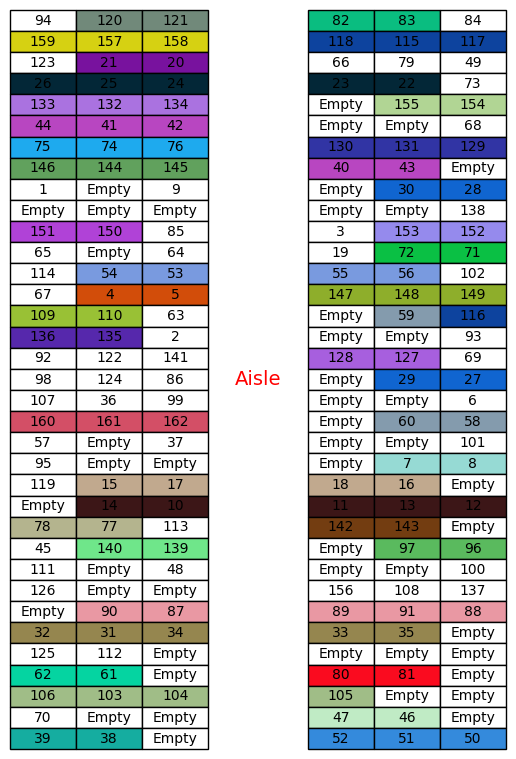

In [253]:
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

In [254]:
## Coupling both objectives

In [255]:
m.setObjective(- 0.7*obj_grouping + 0.3*transit_obj, GRB.MINIMIZE)

m.params.outputflag = 1

m.update()

## Optimisation

In [256]:
# Set iteration limit
m.setParam(GRB.Param.TimeLimit, 100)  # Change to the desired iterationTime limit

m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 207251 rows, 116550 columns and 1017660 nonzeros
Model fingerprint: 0x9ff116c5
Variable types: 0 continuous, 116550 integer (116550 binary)
Coefficient statistics:
  Matrix range     [6e-03, 1e+00]
  Objective range  [4e-03, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]

Loaded MIP start from previous solve with objective -40.2633

Presolve removed 108345 rows and 35392 columns (presolve time = 5s) ...
Presolve removed 108345 rows and 35392 columns (presolve time = 10s) ...
Presolve removed 108345 rows and 35392 columns (presolve time = 31s) ...
Presolve removed 139113 rows and 50776 columns
Presolve time: 32.53s
Presolved: 68138 rows, 65774 columns, 581768 nonzeros
Variable types: 0 continuous, 

- Transit time visualisation

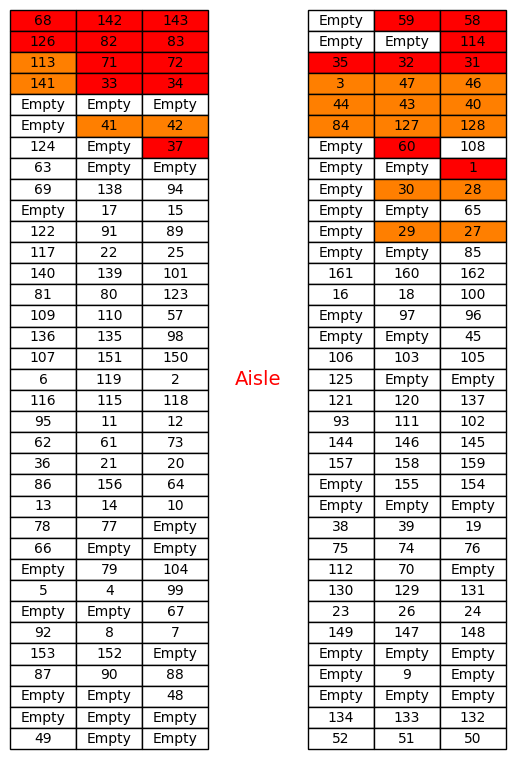

In [257]:
def generate_blue_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
         # Linearly decrease the green component from full (255) to 0
        green_intensity = int(255 * (1 - i / (num_gradations - 1)))
        # Keep the red component at full intensity
        red_intensity = 255
        # Combine the components into a color value
        color_value = f"#{red_intensity:02X}{green_intensity:02X}00"
        gradations.append(color_value)
    return gradations
graduation = generate_blue_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[-i-1]

data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passengers[k]['transit']]
                elif j > 4 :
                    data2[i-1][j-5] = k
                    if Passengers[k]['transit']!=float('inf'): colors2[i-1][j-5] = color_transit[Passengers[k]['transit']]


def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

- Disabled visualization

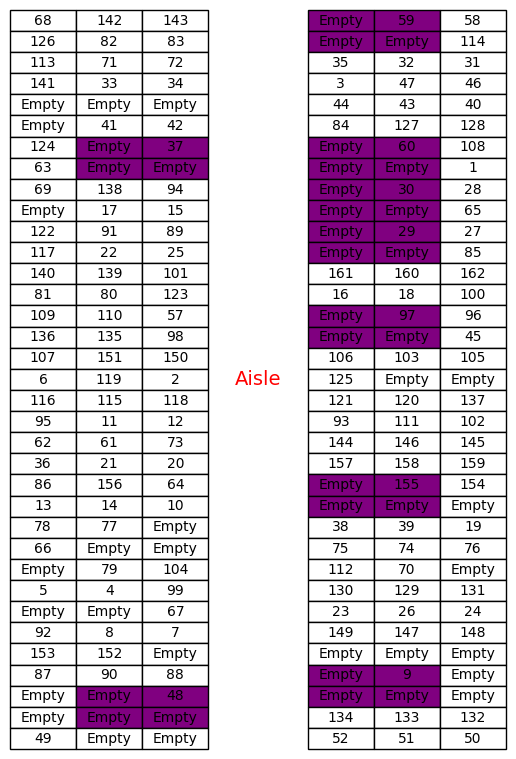

In [258]:

data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passengers[k]['type']==2 :
                        colors1[i-1][j-1] = '#800080'
                        colors1[i-1][j-2] = '#800080'
                        colors1[i][j-1] = '#800080'
                        colors1[i][j-2] = '#800080'
                elif j>4:
                    data2[i-1][j-5] = k
                    if Passengers[k]['type']==2:
                        colors2[i-1][j-5] = '#800080'
                        colors2[i-1][j-6] = '#800080'
                        colors2[i][j-5] = '#800080'
                        colors2[i][j-6] = '#800080'

def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

- Groups vizualisation

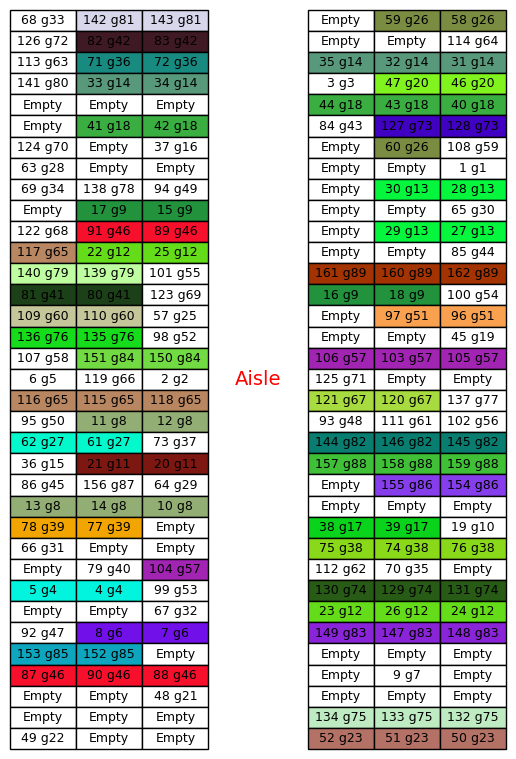

In [259]:

def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

graduation = generate_random_colors(len(Groups))
indices_groups = list(Groups.keys())
color_group = {indices_groups[i-1] : graduation[i-1] for i in range(1, len(Groups)+1) }


data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = f"{k} g{Passengers[k]['group']}"
                    if Passengers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passengers[k]['group']]
                else:
                    data2[i-1][j-5] = f"{k} g{Passengers[k]['group']}"
                    if Passengers[k]['group'] in color_group: colors2[i-1][j-5] = color_group[Passengers[k]['group']]

                    
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Metrics

**Optimal Allocation**

In [287]:
#Seats assignement :

SeatsAssignOptimDict = { (i,j) : None for i in range(1, number_of_rows + 1) for j in range(1, number_of_columns +1)}

#Passengers Assignement :

PassengersAssignOptimDict ={ k : None for k in range(1, len(Passengers) + 1)}

In [288]:
for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passengers) +1 ):
            if round(m.getVarByName(f'x_{i}_{j}_{k}').X,1) == 1:
                SeatsAssignOptimDict[(i, j)] = k
                PassengersAssignOptimDict[k] = [i,j]

**Calculating scores/metrics**

In [393]:
def ScoreTransit(Passengers_Assign_Dict) :
    
    z_transit = sum([Passengers_Assign_Dict[k][0]/Passengers[k]['transit'] for k in range(1, len(Passengers)+1)])

    return (1- (z_transit- z_old)/z_old) * 100

In [394]:
ScoreTransit(PassengersAssignOptimDict)

86.1417522505389

In [395]:
def ScoreGrouping(Passengers_Assign_Dict, Seats_Assign_Dict) :

    satisfaction_scores = []

    for passengers in Groups.values():
            
            for k in passengers :
                i, j = Passengers_Assign_Dict[k]
                satisfaction_k = 0
                if j not in (3,5) :

                    neighbors_k = set([Seats_Assign_Dict.get((i,j-1),0), Seats_Assign_Dict.get((i,j+1),0)])

                    if not neighbors_k.intersection(set(passengers)) :
                        satisfaction_k = 0
                    else :  
                        satisfaction_k = 1
                    
                elif j == 3 : 
                    neighbors_k = set([Seats_Assign_Dict.get((i,j-1),0), Seats_Assign_Dict.get((i,j+2),0)])

                    if not neighbors_k.intersection(set(passengers)) :
                        satisfaction_k = 0
                    elif Seats_Assign_Dict.get((i,j-1),0) in passengers :
                        satisfaction_k = 1
                    else :
                        satisfaction_k = 0.5

                elif j == 5 : 
                    neighbors_k = set([Seats_Assign_Dict.get((i,j+1),0), Seats_Assign_Dict.get((i,j-2),0)])

                    if not neighbors_k.intersection(set(passengers)) :
                        satisfaction_k = 0
                    elif Seats_Assign_Dict.get((i,j+1),0) in passengers :
                        satisfaction_k = 1
                    else :
                        satisfaction_k = 0.5

                satisfaction_scores.append(satisfaction_k)


    # Calcul du score de groupement moyen (pourcentage de satisfaction)
    grouping_score = (sum(satisfaction_scores) / len(satisfaction_scores))*100
    
    return grouping_score

In [396]:
ScoreGrouping(PassengersAssignOptimDict, SeatsAssignOptimDict)

96.42857142857143

## Modèle dynamique

**Passengers Weights**

In [411]:
WeightsPassengers = {}

for k in range(1, len(Passengers) + 1) :
    if Passengers[k]['type'] == 0 :
        WeightsPassengers[k] = weight_f
    if Passengers[k]['type'] == 1 :
        WeightsPassengers[k] = weight_m
    if Passengers[k]['type'] == 2 :
        WeightsPassengers[k] = weight_d

**All Groups**

In [412]:
AllGroups = {}

for i, passager in Passengers.items():
    group_id = passager['group']
    type_i = passager['type']

    # Check if the group already exists in AllGroups
    if group_id in AllGroups:
        group_info = AllGroups[group_id]
    else:
        # If the group doesn't exist, initialize its information
        group_info = {
            'passengers': [],
            'Nbr_female': 0,
            'Nbr_male': 0,
            'Nbr_WCHR': 0
        }
        AllGroups[group_id] = group_info

    # Update passengers list
    group_info['passengers'].append(i)

    # Update passenger type count
    if type_i == 0:
        group_info['Nbr_female'] += 1
    elif type_i == 1:
        group_info['Nbr_male'] += 1
    else:
        group_info['Nbr_WCHR'] += 1



**Functions to select subgroups**

In [413]:
import random

# print(Groups)

def shuffle_groups(group_list, proportion):
    group_list = list(group_list)
    # Mélanger la liste de groupes de manière aléatoire
    random.seed(3)
    random.shuffle(group_list)
    
    # Calculer le nombre de groupes à sélectionner
    num_selected = int(len(group_list) * proportion)
    
    # Sélectionner les groupes en fonction de la proportion spécifiée
    selected_groups = dict(group_list[:num_selected])
    
    return selected_groups


# Appel de la fonction shuffle_groups avec une proportion de 0.5 (50%)
groupes_selectionnes = shuffle_groups(AllGroups.items(), proportion=0.5)


In [414]:
from itertools import combinations

def subgroups(grp_size, valid_seats): 
    
    '''
    This function returns all the sublists of {1, ...., nbr_passengers + 1} of size grp_size
    '''

    if grp_size > len(valid_seats) :
        return []
    elif grp_size < 1:
        return "La taille du groupe doit être d'au moins 1."
    else : 
        return [valid_seats[i: i+grp_size] for i in range(len(valid_seats) - grp_size + 1)]
    

In [415]:
ValidSeats = [(i,j) for i in range(1, number_of_rows + 1) for j in range(1, number_of_columns + 1) if j != 4]
ChosenSeats = []

In [416]:
def potential_permutations(grp_size,chosen_seats):
    
    A=[]
    
    valid_seats =[(i,j) for i in range(1,number_of_rows+1) for j in range(1,number_of_columns+1) if (j != 4 and (i,j) not in chosen_seats) ]
    
    choices = subgroups(grp_size,valid_seats)
    
    return choices

In [417]:
potential_permutations(2, [])

[[(1, 1), (1, 2)],
 [(1, 2), (1, 3)],
 [(1, 3), (1, 5)],
 [(1, 5), (1, 6)],
 [(1, 6), (1, 7)],
 [(1, 7), (2, 1)],
 [(2, 1), (2, 2)],
 [(2, 2), (2, 3)],
 [(2, 3), (2, 5)],
 [(2, 5), (2, 6)],
 [(2, 6), (2, 7)],
 [(2, 7), (3, 1)],
 [(3, 1), (3, 2)],
 [(3, 2), (3, 3)],
 [(3, 3), (3, 5)],
 [(3, 5), (3, 6)],
 [(3, 6), (3, 7)],
 [(3, 7), (4, 1)],
 [(4, 1), (4, 2)],
 [(4, 2), (4, 3)],
 [(4, 3), (4, 5)],
 [(4, 5), (4, 6)],
 [(4, 6), (4, 7)],
 [(4, 7), (5, 1)],
 [(5, 1), (5, 2)],
 [(5, 2), (5, 3)],
 [(5, 3), (5, 5)],
 [(5, 5), (5, 6)],
 [(5, 6), (5, 7)],
 [(5, 7), (6, 1)],
 [(6, 1), (6, 2)],
 [(6, 2), (6, 3)],
 [(6, 3), (6, 5)],
 [(6, 5), (6, 6)],
 [(6, 6), (6, 7)],
 [(6, 7), (7, 1)],
 [(7, 1), (7, 2)],
 [(7, 2), (7, 3)],
 [(7, 3), (7, 5)],
 [(7, 5), (7, 6)],
 [(7, 6), (7, 7)],
 [(7, 7), (8, 1)],
 [(8, 1), (8, 2)],
 [(8, 2), (8, 3)],
 [(8, 3), (8, 5)],
 [(8, 5), (8, 6)],
 [(8, 6), (8, 7)],
 [(8, 7), (9, 1)],
 [(9, 1), (9, 2)],
 [(9, 2), (9, 3)],
 [(9, 3), (9, 5)],
 [(9, 5), (9, 6)],
 [(9, 6), (9

In [418]:
AllGroups

{1: {'passengers': [1], 'Nbr_female': 1, 'Nbr_male': 0, 'Nbr_WCHR': 0},
 2: {'passengers': [2], 'Nbr_female': 0, 'Nbr_male': 1, 'Nbr_WCHR': 0},
 3: {'passengers': [3], 'Nbr_female': 1, 'Nbr_male': 0, 'Nbr_WCHR': 0},
 4: {'passengers': [4, 5], 'Nbr_female': 1, 'Nbr_male': 1, 'Nbr_WCHR': 0},
 5: {'passengers': [6], 'Nbr_female': 1, 'Nbr_male': 0, 'Nbr_WCHR': 0},
 6: {'passengers': [7, 8], 'Nbr_female': 2, 'Nbr_male': 0, 'Nbr_WCHR': 0},
 7: {'passengers': [9], 'Nbr_female': 0, 'Nbr_male': 0, 'Nbr_WCHR': 1},
 8: {'passengers': [10, 11, 12, 13, 14],
  'Nbr_female': 1,
  'Nbr_male': 4,
  'Nbr_WCHR': 0},
 9: {'passengers': [15, 16, 17, 18],
  'Nbr_female': 4,
  'Nbr_male': 0,
  'Nbr_WCHR': 0},
 10: {'passengers': [19], 'Nbr_female': 1, 'Nbr_male': 0, 'Nbr_WCHR': 0},
 11: {'passengers': [20, 21], 'Nbr_female': 1, 'Nbr_male': 1, 'Nbr_WCHR': 0},
 12: {'passengers': [22, 23, 24, 25, 26],
  'Nbr_female': 5,
  'Nbr_male': 0,
  'Nbr_WCHR': 0},
 13: {'passengers': [27, 28, 29, 30],
  'Nbr_female': 2,

In [419]:
def permutation(Old_allocation,New_allocation,Passengers_Assign_old_Dict,Seats_Assign_old_Dict):

    Passengers_Assign_New_Dict , Seats_Assign_New_Dict = Passengers_Assign_old_Dict.copy() , Seats_Assign_old_Dict.copy()

    for l in range(len(Old_allocation)) :

        Passenger_Assign_Old = Old_allocation[l][2]
        Seat_Assign_New = (New_allocation[l][0], New_allocation[l][1])
        Passenger_Assign_New = New_allocation[l][2]
        Seat_Assign_Old = (Old_allocation[l][0], Old_allocation[l][1])

        Seats_Assign_New_Dict[Passenger_Assign_Old] = Seat_Assign_New
        Seats_Assign_New_Dict[Passenger_Assign_New] = Seat_Assign_Old
        Passengers_Assign_New_Dict[Seat_Assign_New] = Passenger_Assign_Old
        Passengers_Assign_New_Dict[Seat_Assign_Old] = Passenger_Assign_New
        
    return Passengers_Assign_New_Dict , Seats_Assign_New_Dict

In [420]:
def CheckBaryConst(Passengers_Assign_Dict):

    res = True 
    
    i_bary = sum([WeightsPassengers[k]*Passengers_Assign_Dict[k][0] for k in range(1, len(Passengers) + 1)])/sum(WeightsPassengers.values())
    j_bary = sum([WeightsPassengers[k]*Passengers_Assign_Dict[k][1] for k in range(1, len(Passengers) + 1)])/sum(WeightsPassengers.values())

    if i_bary > 17 or i_bary < 13 or j_bary > 5 or 3 > j_bary :
        res = False 

    return res

In [421]:
def CheckWCHConst(Passengers_Assign_Dict , Seats_Assign_Dict):

    res = True 
    for k in range(1, len(Passengers) + 1) :
        if Passengers[k]['type'] == 2 :
            i,j = Passengers_Assign_Dict[k]
            if j not in [3,6] or Seats_Assign_Dict[i,j-1] != None or Seats_Assign_Dict[i+1,j-1] != None  or Seats_Assign_Dict[i+1,j] != None :
                res = False 
                break

    return res

In [422]:

def CheckNewAllocation(Passengers_Assign_Dict,Seats_Assign_Dict):

    res = True 

    if not CheckBaryConst(Passengers_Assign_Dict):
        res = False
        return res

    if not CheckWCHConst(Passengers_Assign_Dict, Seats_Assign_Dict):
        res = False 
        return res

    if ScoreTransit(Passengers_Assign_Dict)/ScoreTransit(PassengersAssignOptimDict) < 0.99 or ScoreTransit(Passengers_Assign_Dict)/ScoreTransit(PassengersAssignOptimDict) > 1.1:
        res = False
        return res
    
    if ScoreGrouping(Passengers_Assign_Dict, Seats_Assign_Dict)/ScoreGrouping(PassengersAssignOptimDict, SeatsAssignOptimDict) < 0.99 or ScoreGrouping(Passengers_Assign_Dict, Seats_Assign_Dict)/ScoreGrouping(PassengersAssignOptimDict, SeatsAssignOptimDict) > 1.1:
        res = False


    return res


In [423]:
def possible_permutations(group_number, chosen_seats, Passengers_Assign_old_Dict , Seats_Assign_old_Dict):

    grp_size = len(AllGroups[group_number]['passengers'])
    optimal_allocation_group = [(PassengersAssignOptimDict[k][0], PassengersAssignOptimDict[k][1],k) for k in AllGroups[group_number]['passengers']]
    res = [optimal_allocation_group]

    for allocation in potential_permutations(grp_size , chosen_seats) :
        allocation_group = [(seat[0],seat[1],SeatsAssignOptimDict[(seat[0],seat[1])]) for seat in allocation]
        PassengersAssignNewDict , SeatsAssignNewDict = permutation(optimal_allocation_group,allocation_group, Passengers_Assign_old_Dict , Seats_Assign_old_Dict)
        if CheckNewAllocation(PassengersAssignNewDict,SeatsAssignNewDict) : 
            res.append(allocation_group)

    return res


    




In [424]:
PassengersAssignOldDict , SeatsAssignOldDict = PassengersAssignOptimDict.copy() , SeatsAssignOptimDict.copy()
possible_permutations(6,[], PassengersAssignOldDict , SeatsAssignOldDict)

[[(30, 3, 7), (30, 2, 8)],
 [(1, 1, 68), (1, 2, 142)],
 [(1, 2, 142), (1, 3, 143)],
 [(1, 3, 143), (1, 5, None)],
 [(1, 5, None), (1, 6, 59)],
 [(1, 6, 59), (1, 7, 58)],
 [(1, 7, 58), (2, 1, 126)],
 [(2, 1, 126), (2, 2, 82)],
 [(2, 2, 82), (2, 3, 83)],
 [(2, 3, 83), (2, 5, None)],
 [(2, 5, None), (2, 6, None)],
 [(2, 6, None), (2, 7, 114)],
 [(2, 7, 114), (3, 1, 113)],
 [(3, 1, 113), (3, 2, 71)],
 [(3, 2, 71), (3, 3, 72)],
 [(3, 3, 72), (3, 5, 35)],
 [(3, 5, 35), (3, 6, 32)],
 [(3, 6, 32), (3, 7, 31)],
 [(3, 7, 31), (4, 1, 141)],
 [(4, 1, 141), (4, 2, 33)],
 [(4, 2, 33), (4, 3, 34)],
 [(4, 3, 34), (4, 5, 3)],
 [(4, 5, 3), (4, 6, 47)],
 [(4, 6, 47), (4, 7, 46)],
 [(4, 7, 46), (5, 1, 54)],
 [(5, 1, 54), (5, 2, 53)],
 [(5, 2, 53), (5, 3, 56)],
 [(5, 3, 56), (5, 5, 44)],
 [(5, 5, 44), (5, 6, 43)],
 [(5, 6, 43), (5, 7, 40)],
 [(5, 7, 40), (6, 1, 55)],
 [(6, 1, 55), (6, 2, 41)],
 [(6, 2, 41), (6, 3, 42)],
 [(6, 3, 42), (6, 5, 84)],
 [(6, 5, 84), (6, 6, 127)],
 [(6, 6, 127), (6, 7, 128)],
 [(

In [425]:
allocation = [(1, 1), (1, 2)]
for seat in allocation:
    print(seat[0])
    print(seat[1])
    print(SeatsAssignOptimDict[(seat[0], seat[1])]) for seat in allocation]
)
allocation_group = [(
    seat[0],
    seat[1],
    SeatsAssignOptimDict(   (seat[0],seat[1]))   ) 
                     for seat in allocation]
allocation_group

SyntaxError: unmatched ']' (2967813822.py, line 5)

In [ ]:
RegisteredGroups=set()

**Checking Constraints**

In [ ]:
CheckBaryConst(PassengersAssignOptimDict)

True

In [ ]:
CheckWCHConst(PassengersAssignOptimDict, SeatsAssignOptimDict)

True

SyntaxError: expected ':' (2255275151.py, line 1)

{}
Groupes sélectionnés et leurs groupes associés pour permutation:
